### CamemBERT

Fine tune modèle camembert

Deuxième modèle qui fait NER et trouve les entités de lieu

#### Imports

In [36]:
import pandas as pd

from transformers import CamembertTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, TrainerCallback, EarlyStoppingCallback, AutoTokenizer
import torch
from torch.utils.data import Dataset, random_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

import random

#### Création du dataset de TRAIN

In [37]:
df_valid = pd.read_csv('valid_sentences_train_dataset.csv')
df_invalid = pd.read_csv('invalid_sentences_train_dataset.csv')

df_combined = pd.concat([df_valid, df_invalid], ignore_index=True)

print("Valeurs manquantes avant traitement :")
print(df_combined.isnull().sum())

train_sentences = df_combined['sentence'].tolist()
train_labels = df_combined['label'].tolist()

print(df_combined['label'].value_counts())
print(df_combined.shape)

Valeurs manquantes avant traitement :
sentence    0
label       0
dtype: int64
label
1    2000
0    2000
Name: count, dtype: int64
(4000, 2)


#### Création du dataset de TEST

In [38]:
df_valid = pd.read_csv('valid_sentences_test_dataset.csv')
df_invalid = pd.read_csv('invalid_sentences_test_dataset.csv')

df_combined = pd.concat([df_valid, df_invalid], ignore_index=True)

print("Valeurs manquantes avant traitement :")
print(df_combined.isnull().sum())

test_sentences = df_combined['sentence'].tolist()
test_labels = df_combined['label'].tolist()

print(df_combined['label'].value_counts())
print(df_combined.shape)

Valeurs manquantes avant traitement :
sentence    0
label       0
dtype: int64
label
1    500
0    500
Name: count, dtype: int64
(1000, 2)


In [39]:
random_indices = random.sample(range(len(train_sentences)), 20)

for idx in random_indices:
    print(train_sentences[idx])

I need to go to Jeuxey from Saint-Sauvant
À La Haute-Maison, j'ai visité une magnifique cave à vin.
Quel est le prochain train pour Grumesnil ?
Quel est le prochain train ?
Comment aller à Sainte-Ouenne, en passant par Haut-Lieu, depuis Sivry ?
Comment puis-je aller à Asnières-en-Montagne ?
De Nieulle-sur-Seudre, je me rendrai à Vougrey en passant par Claix.
Voyage de Pexiora à Gonfreville-l'Orcher avec un arrêt à Chisa.
J'ai prévu de prendre le train à Saint-Mard pour aller à Villard-Léger.
Comment puis-je me rendre de Saint-André à Saint-Quay-Portrieux ?
Je pars de Annequin pour aller à Nostang, avec un arrêt à Gruchet-le-Valasse.
Aller de Beaulieu-en-Argonne à Avenay-Val-d'Or via Brassy.
Je cherche un billet.
Le château de Saint-Palais-du-Né est un chef-d'œuvre de la Renaissance.
Je voudrais un billet de Saint-Romain-le-Noble à Saulzais-le-Potier.
Y a-t-il des trains demain ?
J'ai prévu de prendre le train à Saverdun pour aller à Ferrières.
I would like a ticket to Saint-Victor-l'Ab

#### Les modèles

##### Model Camembert Base

In [40]:
# charge le tokenizer pré-entraîné pour le modèle camembert-base
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

##### Model Distil Camembert

The aim of distillation is to drastically reduce the complexity of the model while preserving the performances.

In [41]:
# charge le tokenizer pré-entraîné pour le modèle distilcamembert-base
# tokenizer = CamembertTokenizer.from_pretrained("cmarkea/distilcamembert-base")

# tokenizer roberta-base
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

#### Classe pour créer un dataset personnalisé

In [42]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

#### Création des datasets d'entraînement et de test

In [ ]:
train_dataset = CustomDataset(train_sentences, train_labels, tokenizer)
test_dataset = CustomDataset(test_sentences, test_labels, tokenizer)

#### Entraînement du modèle

In [44]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    save_total_limit=1,
)

In [45]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    return {
        'f1': f1,
        'recall': recall,
        'precision': precision,
    }

In [46]:
# model distil camambert
model = AutoModelForSequenceClassification.from_pretrained("cmarkea/distilcamembert-base", num_labels=2)

# model roberta
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
train_loss = []
eval_loss = []

class LossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                train_loss.append(logs['loss'])
            if 'eval_loss' in logs:
                eval_loss.append(logs['eval_loss'])

In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LossCallback(), EarlyStoppingCallback(early_stopping_patience=3)]
)

loss_callback = LossCallback()
trainer.add_callback(loss_callback)

You are adding a <class '__main__.LossCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
LossCallback
EarlyStoppingCallback
ProgressCallback


In [49]:
# Validation curve taille du dataset
# # Enregistrer les pertes d'entraînement et d'évaluation
# train_sizes = [6000, len(train_dataset)]
# train_loss = []
# eval_loss = []

# class LossCallback(TrainerCallback):
#     def __init__(self):
#         super().__init__()
#         self.train_loss = []
#         self.eval_loss = []

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         if logs is not None:
#             if 'loss' in logs:
#                 self.train_loss.append(logs['loss'])
#             if 'eval_loss' in logs:
#                 self.eval_loss.append(logs['eval_loss'])

In [71]:
# for train_size in train_sizes:
#     # Diviser les données d'entraînement
#     subset_train_dataset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
    
#     # Définir le trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=subset_train_dataset,
#         eval_dataset=test_dataset,
#         compute_metrics=compute_metrics
#     )
    
#     # Ajouter le callback pour enregistrer les pertes
#     loss_callback = LossCallback()
#     trainer.add_callback(loss_callback)
    
#     # Entraîner le modèle
#     trainer.train()
    
#     # Évaluer le modèle
#     eval_result = trainer.evaluate()
    
#     # Enregistrer les pertes
#     train_loss.append(loss_callback.train_loss[-1])
#     eval_loss.append(eval_result['eval_loss'])

In [51]:
trainer.train()

  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 0.7033, 'grad_norm': 0.7918808460235596, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.08}
{'loss': 0.6785, 'grad_norm': 1.7575401067733765, 'learning_rate': 9.466666666666667e-06, 'epoch': 0.16}
{'loss': 0.5795, 'grad_norm': 5.455897331237793, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.24}
{'loss': 0.4465, 'grad_norm': 7.588300704956055, 'learning_rate': 8.933333333333333e-06, 'epoch': 0.32}
{'loss': 0.2247, 'grad_norm': 7.117885112762451, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}
{'loss': 0.138, 'grad_norm': 12.063962936401367, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.48}
{'loss': 0.0754, 'grad_norm': 5.762347221374512, 'learning_rate': 8.133333333333334e-06, 'epoch': 0.56}
{'loss': 0.0501, 'grad_norm': 9.858536720275879, 'learning_rate': 7.866666666666667e-06, 'epoch': 0.64}
{'loss': 0.0198, 'grad_norm': 0.9249831438064575, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.72}
{'loss': 0.0038, 'grad_norm': 0.2577565908432007, 'learning_ra

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8371591567993164, 'eval_f1': 0.8706366182606944, 'eval_recall': 0.871, 'eval_precision': 0.8752159261461785, 'eval_runtime': 65.51, 'eval_samples_per_second': 15.265, 'eval_steps_per_second': 0.488, 'epoch': 1.0}
{'loss': 0.0154, 'grad_norm': 0.6741790175437927, 'learning_rate': 6.533333333333334e-06, 'epoch': 1.04}
{'loss': 0.0252, 'grad_norm': 0.026616862043738365, 'learning_rate': 6.266666666666668e-06, 'epoch': 1.12}
{'loss': 0.0183, 'grad_norm': 0.0218728706240654, 'learning_rate': 6e-06, 'epoch': 1.2}
{'loss': 0.0017, 'grad_norm': 0.02130286395549774, 'learning_rate': 5.733333333333334e-06, 'epoch': 1.28}
{'loss': 0.0008, 'grad_norm': 0.020386952906847, 'learning_rate': 5.466666666666667e-06, 'epoch': 1.36}
{'loss': 0.0014, 'grad_norm': 0.023128265514969826, 'learning_rate': 5.2e-06, 'epoch': 1.44}
{'loss': 0.0016, 'grad_norm': 0.021605098620057106, 'learning_rate': 4.933333333333334e-06, 'epoch': 1.52}
{'loss': 0.0007, 'grad_norm': 0.15017740428447723, 'learning_

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8164201378822327, 'eval_f1': 0.8989465427210995, 'eval_recall': 0.899, 'eval_precision': 0.8998460742932044, 'eval_runtime': 62.4417, 'eval_samples_per_second': 16.015, 'eval_steps_per_second': 0.512, 'epoch': 2.0}
{'loss': 0.0005, 'grad_norm': 0.011160927824676037, 'learning_rate': 3.066666666666667e-06, 'epoch': 2.08}
{'loss': 0.0012, 'grad_norm': 0.010154305957257748, 'learning_rate': 2.8000000000000003e-06, 'epoch': 2.16}
{'loss': 0.0005, 'grad_norm': 0.012060857377946377, 'learning_rate': 2.5333333333333338e-06, 'epoch': 2.24}
{'loss': 0.0176, 'grad_norm': 0.01020019594579935, 'learning_rate': 2.266666666666667e-06, 'epoch': 2.32}
{'loss': 0.0005, 'grad_norm': 0.011150924488902092, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}
{'loss': 0.0223, 'grad_norm': 0.011556720361113548, 'learning_rate': 1.7333333333333336e-06, 'epoch': 2.48}
{'loss': 0.0006, 'grad_norm': 0.0107249915599823, 'learning_rate': 1.4666666666666669e-06, 'epoch': 2.56}
{'loss': 0.0004, 'g

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.9942201972007751, 'eval_f1': 0.86939608750864, 'eval_recall': 0.87, 'eval_precision': 0.8769724830464266, 'eval_runtime': 64.5444, 'eval_samples_per_second': 15.493, 'eval_steps_per_second': 0.496, 'epoch': 3.0}
{'train_runtime': 2831.1841, 'train_samples_per_second': 4.239, 'train_steps_per_second': 0.132, 'train_loss': 0.08138997226705154, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.08138997226705154, metrics={'train_runtime': 2831.1841, 'train_samples_per_second': 4.239, 'train_steps_per_second': 0.132, 'total_flos': 789333166080000.0, 'train_loss': 0.08138997226705154, 'epoch': 3.0})

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_loss, label='Training Loss')
plt.plot(train_sizes, eval_loss, label='Validation Loss')
plt.xlabel('Training Data Size')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

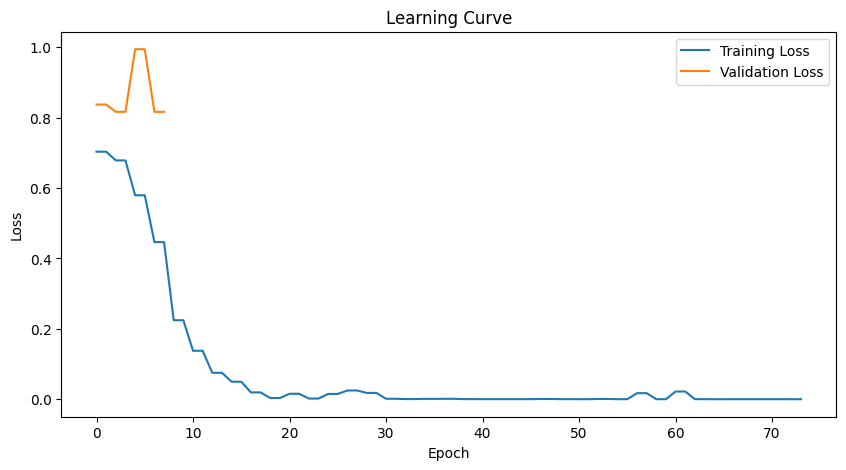

In [ ]:
eval_result = trainer.evaluate()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [55]:
def print_random_examples(dataset, num_examples=5):
    indices = random.sample(range(len(dataset)), num_examples)
    for idx in indices:
        example = dataset[idx]
        sentence = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
        label = example['labels'].item()
        print(f"Sentence: {sentence}")
        print(f"Label: {label}")
        print("-" * 50)

# Imprimer des exemples aléatoires du dataset d'entraînement
print("Exemples aléatoires du dataset d'entraînement :")
print_random_examples(train_dataset)

# Imprimer des exemples aléatoires du dataset de test
print("\nExemples aléatoires du dataset de test :")
print_random_examples(test_dataset)

Exemples aléatoires du dataset d'entraînement :
Sentence: Pouvez-vous me trouver un train de ?
Label: 0
--------------------------------------------------
Sentence: Route à suivre de Framecourt à Espinasse-Vozelle.
Label: 1
--------------------------------------------------
Sentence: Quel est le prochain train de Gréning à Saint-Christophe-en-Oisans ?Je voudrais trouver un train de Gréning à Saint-Christophe-en-Oisans ?
Label: 1
--------------------------------------------------
Sentence: Le château de Roiffieux est un chef-d'œuvre de la Renaissance.
Label: 0
--------------------------------------------------
Sentence: Je veux aller à Huby-Saint-Leu en partant de Souffrignac
Label: 1
--------------------------------------------------

Exemples aléatoires du dataset de test :
Sentence: J'ai prévu de quitter Cussy-le-Châtel pour se rendre à Verneuil via Saint-Léry.
Label: 1
--------------------------------------------------
Sentence: J'ai prévu de quitter Billième pour se rendre à Averme

#### Sauvegarder le modèle

In [56]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.json',
 './saved_model\\merges.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')

#### Benchmark autres modèles

In [57]:
# model_names = [
#     "bert-base-uncased",
#     "roberta-base",
#     "distilbert-base-uncased",
#     "albert-base-v2",
#     "xlnet-base-cased",
#     "camembert-base"
# ]

# f1_scores = []
# recall_scores = []
# precision_scores = []

In [58]:
# for model_name in model_names:
#     print(f"Testing model: {model_name}")
    
#     # Charger le tokenizer et le modèle
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
#     # Créer les datasets de train et de test
#     train_dataset = CustomDataset(train_sentences, train_labels, tokenizer)
#     test_dataset = CustomDataset(test_sentences, test_labels, tokenizer)
    
#     # Définir les arguments d'entraînement
#     training_args = TrainingArguments(
#         output_dir='./results',
#         learning_rate=1e-5,
#         per_device_train_batch_size=32,
#         per_device_eval_batch_size=32,
#         num_train_epochs=2,
#         weight_decay=0.01,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         logging_steps=10,
#     )
    
#     # Définir le trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=test_dataset,
#         compute_metrics=compute_metrics
#     )
    
#     # Entraîner le modèle
#     trainer.train()
    
#     # Évaluer le modèle
#     eval_result = trainer.evaluate()
    
#     # Enregistrer les métriques
#     f1_scores.append(eval_result['eval_f1'])
#     recall_scores.append(eval_result['eval_recall'])
#     precision_scores.append(eval_result['eval_precision'])

In [59]:
# # Tracer les résultats
# plt.figure(figsize=(12, 6))
# x = range(len(model_names))
# plt.bar(x, f1_scores, width=0.2, label='F1 Score', align='center')
# plt.bar(x, recall_scores, width=0.2, label='Recall', align='edge')
# plt.bar(x, precision_scores, width=0.2, label='Precision', align='edge')
# plt.xlabel('Models')
# plt.ylabel('Scores')
# plt.xticks(x, model_names, rotation=45)
# plt.legend()
# plt.title('Model Performance Comparison')
# plt.show()

#### Évaluation du modèle

In [60]:
model = trainer.model
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [61]:
# Préparer les données de test
test_encodings = tokenizer(test_sentences, truncation=True, padding=True)
test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])

In [62]:
# Prédictions
with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)
    print(predictions)

tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [63]:
# Calcul des métriques
f1 = f1_score(test_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
recall = recall_score(test_labels, predictions, average='weighted')
print(f"Recall: {recall:.4f}")
precision = precision_score(test_labels, predictions, average='weighted')
print(f"Precision: {precision:.4f}")

F1 Score: 0.8989
Recall: 0.8990
Precision: 0.8998


#### Matrice de confusion

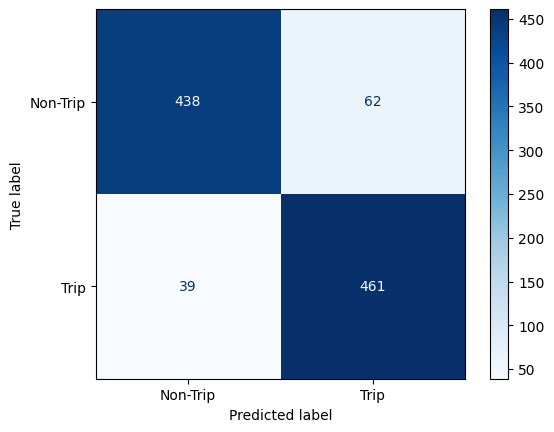

In [64]:
# Convertir les prédictions et les labels en numpy array
if isinstance(predictions, torch.Tensor):
    predictions = predictions.numpy()
test_labels = np.array(test_labels)

cm = confusion_matrix(test_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Trip', 'Trip'])
disp.plot(cmap='Blues')
plt.show()

### Fonction pour tester le modèle avec 1 phrase

In [65]:
def predict_sentence(model, tokenizer, sentence):
    model.eval()
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return prediction

In [70]:
test_sentence = "Je voudrais un billet de Brest à Nantes"

prediction = predict_sentence(model, tokenizer, test_sentence)
print(f"Prediction for '{test_sentence}': {prediction}")

Prediction for 'Je voudrais un billet de Brest à Nantes': 1


#### Push to hugging face

In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# from huggingface_hub import notebook_login, login

# # Connexion à Hugging Face (nécessaire une seule fois)
# # notebook_login()
# login(token="place_your_token_here")

# # Chemin de ton modèle local
# model_path = "./saved_model"

# # Nom du repo Hugging Face (choisis un nom unique)
# repo_name = "place_your_repo_name_here"

# # Charger le modèle et le tokenizer
# model = AutoModelForSequenceClassification.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path)

# # Envoyer sur Hugging Face
# model.push_to_hub(repo_name)
# tokenizer.push_to_hub(repo_name)

# print(f"Modèle publié sur : https://huggingface.co/{repo_name}")